# SRR with LR FLAIR images

### Import modules and define functions

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

import pylops
import imwip
import storm

from time import time
from tqdm import tqdm

In [13]:
def show_orthoslices(image, cross = None, figsize = (18,6), cmap = "gray"):
    slices = [image[cross[0], :, :], image[:, cross[1], :], image[:, :, cross[2]]]
    dims = [("Dimension 2", "Dimension 3"), ("Dimension 1", "Dimension 3"), ("Dimension 1", "Dimension 2")]

    # create plots and save image
    fig, axes = plt.subplots(1, len(slices), figsize = figsize)
    ims = []
    for i, slice in enumerate(slices):
        # subplots, labels and colorbars
        im = axes[i].imshow(slice.T, cmap = cmap, origin = "lower", interpolation = "none")
        axes[i].set_xlabel(dims[i][0])
        axes[i].set_ylabel(dims[i][1])
        axes[i].set_aspect(slice.shape[0]/slice.shape[1])
        axes[i].set_xticks([]) 
        axes[i].set_yticks([])
        ims.append(im)

    left = axes[0].get_position().x0
    bottom = axes[0].get_position().y1 + 0.05
    width = abs(axes[0].get_position().x0 - axes[2].get_position().x1)
    height = 0.02
    cax = fig.add_axes([left, bottom, width, height])
    fig.colorbar(ims[0], cax=cax, orientation="horizontal")
    
    plt.show()
    plt.close()

## Specify case

In [14]:
# Processed MRI dir
PRO_DIR="/home/vlab/MS_proj/processed_MRI"

CASE="2400402"
DATE="20170227"

## Read HR template and grid

Image array shape: [250 250 141]
Orientation of voxel axes: ('L', 'P', 'S')
Image affine transformation:
 [[-9.97489274e-01 -2.64146533e-02  6.57071769e-02  1.26011154e+02]
 [ 3.89513820e-02 -9.79520380e-01  1.97541505e-01  1.42383072e+02]
 [ 5.91435283e-02  1.99604943e-01  9.78089929e-01 -8.54139404e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Voxel size: [1. 1. 1.]


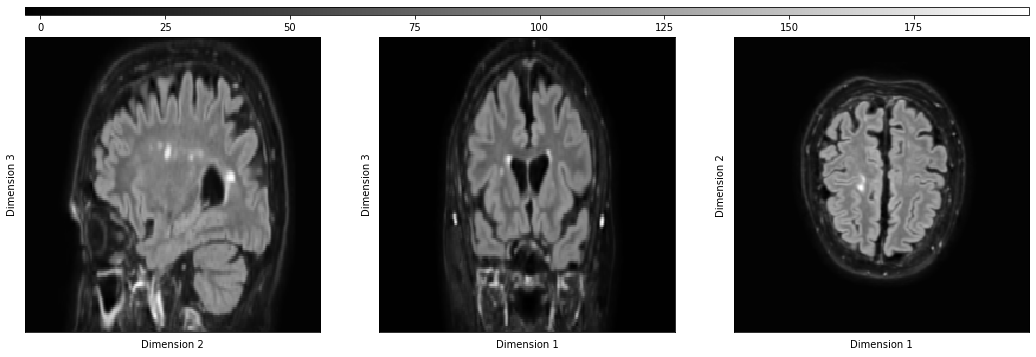

In [53]:
HR_fpath = PRO_DIR + "/sub-" + CASE + "/ses-" + DATE + "/anat/HR_FLAIR_interp.nii.gz"

HR = nib.load(HR_fpath)

HR_dim = np.array(HR.shape)
HR_vox = np.array(HR.header.get_zooms())
HR_v2w = HR.affine
HR_ori = nib.aff2axcodes(HR_v2w)

print('Image array shape:', HR_dim)
print('Orientation of voxel axes:', HR_ori)
print('Image affine transformation:\n', HR_v2w)
print('Voxel size:', HR_vox)
show_orthoslices(HR.get_fdata(), [100, 100, 100])

## Read LR images

Number of LR images in folder: 3
--------------------------------------------------
IMAGE 1
Image array shape: (512, 512, 45)
Orientation of voxel axes: ('L', 'P', 'S')
Image affine transformation:
 [[-4.87055302e-01 -1.28977792e-02  1.97121531e-01  1.26535896e+02]
 [ 1.90192293e-02 -4.78281409e-01  5.92624545e-01  1.43413834e+02]
 [ 2.88786758e-02  9.74633470e-02  2.93426991e+00 -8.15677643e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Voxel size: (0.48828125, 0.48828125, 3.0)


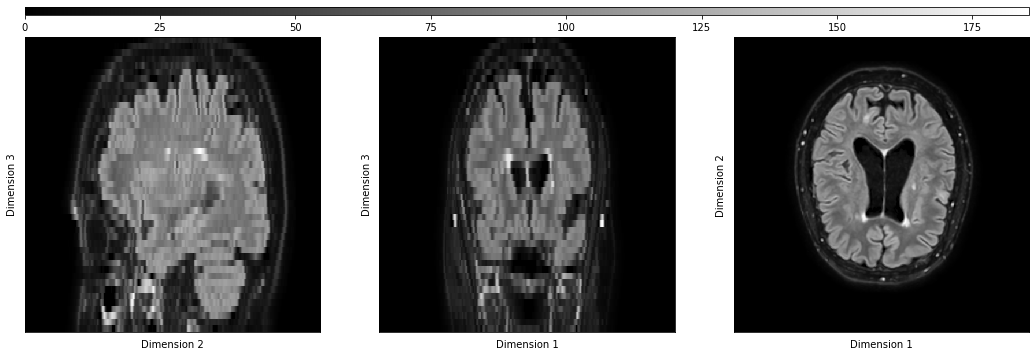

--------------------------------------------------
IMAGE 2
Image array shape: (512, 512, 45)
Orientation of voxel axes: ('P', 'I', 'R')
Image affine transformation:
 [[-1.28977792e-02 -3.20835859e-02  2.99246788e+00 -5.09795074e+01]
 [-4.78281438e-01 -9.64558199e-02 -1.16854146e-01  1.88468506e+02]
 [ 9.74633470e-02 -4.77582961e-01 -1.77430600e-01  1.16037361e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Voxel size: (0.48828125, 0.48828125, 3.0)


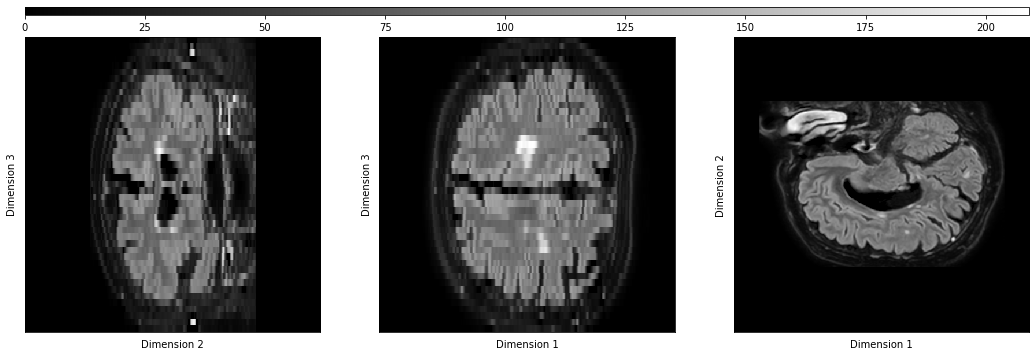

--------------------------------------------------
IMAGE 3
Image array shape: (512, 512, 45)
Orientation of voxel axes: ('L', 'I', 'P')
Image affine transformation:
 [[-4.87055302e-01 -3.20835859e-02 -7.92439580e-02  1.37508316e+02]
 [ 1.90192293e-02 -9.64558125e-02 -2.93856096e+00  1.23734390e+02]
 [ 2.88786795e-02 -4.77582961e-01  5.98814785e-01  1.16449059e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Voxel size: (0.48828125, 0.48828125, 3.0)


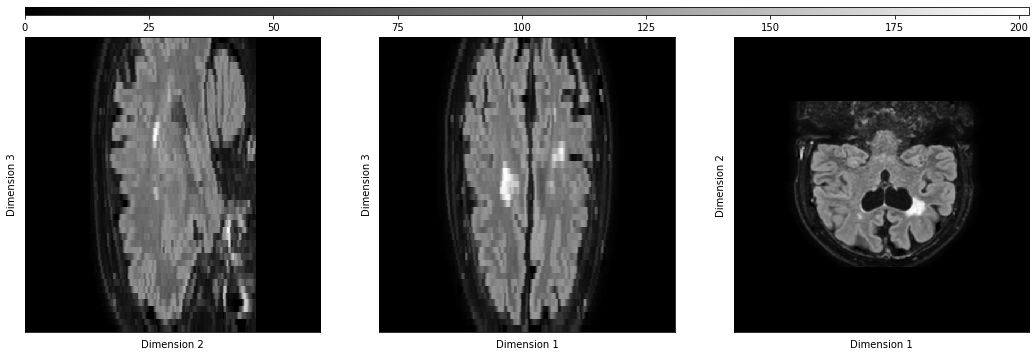

In [54]:
LR_dir = PRO_DIR + "/sub-" + CASE + "/ses-" + DATE + "/anat/LR_FLAIR_hmatch"

LR = [nib.load(os.path.join(LR_dir, file)) for file in os.listdir(LR_dir)]

# Detect Image aligned with HR template and put it first
first_lr = [nib.aff2axcodes(img.affine) for img in LR].index(HR_ori)
LR[0], LR[first_lr] = LR[first_lr], LR[0]

print("Number of LR images in folder:", len(LR))

for n, img in enumerate(LR):
    print("--------------------------------------------------")
    print("IMAGE", n+1)
    print('Image array shape:', img.shape)
    print('Orientation of voxel axes:', nib.aff2axcodes(img.affine))
    print('Image affine transformation:\n', img.affine)
    print('Voxel size:', img.header.get_zooms())
    show_orthoslices(img.get_fdata(), [200, 200, 25])

In [57]:
# Data order close to canonical 

HR = nib.as_closest_canonical(HR)
LR[0] = nib.as_closest_canonical(LR[0])

HR_ornt = nib.orientations.io_orientation(HR.affine)
for img in LR[1:]:
    LR_ornt = nib.orientations.io_orientation(img.affine)
    tmp_transf = nib.orientations.ornt_transform(HR_ornt, LR_ornt).astype(np.int32)

Image array shape: (512, 512, 45)
Orientation of voxel axes: ('P', 'I', 'R')
Image array shape: (512, 512, 45)
Orientation of voxel axes: ('L', 'I', 'P')


## Construct operators

### Change of coordinates

In [46]:
R = []

HR_ornt = nib.orientations.io_orientation(HR.affine)
for img in LR:
    print("--------------------------------------------------")
    print("Orientation HR: ", HR_ori)
    print("Orientation LR: ", nib.aff2axcodes(img.affine))
    LR_ornt = nib.orientations.io_orientation(img.affine)
    tmp_transf = nib.orientations.ornt_transform(HR_ornt, LR_ornt).astype(np.int32)
    perm_mat = np.zeros((3,3))
    perm_mat[0,tmp_transf[0,0]] = tmp_transf[0,1]
    perm_mat[1,tmp_transf[1,0]] = tmp_transf[1,1]
    perm_mat[2,tmp_transf[2,0]] = tmp_transf[2,1]
    R.append(R)
    print(perm_mat)

# Create a function that executes the change of coordinates depending on the permutation matrix and input image dimension
def change_coord_fn(perm_mat, in_shape, x):
    perm_dim = np.abs(np.dot(perm_mat, np.arange(3))).astype(np.int32)
    x = x.reshape(in_shape)
    x = np.transpose(x, perm_dim)
    return x.ravel()

--------------------------------------------------
Orientation HR:  ('L', 'P', 'S')
Orientation LR:  ('L', 'P', 'S')
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------------------------------------
Orientation HR:  ('L', 'P', 'S')
Orientation LR:  ('P', 'I', 'R')
[[ 0.  0. -1.]
 [ 1.  0.  0.]
 [ 0. -1.  0.]]
--------------------------------------------------
Orientation HR:  ('L', 'P', 'S')
Orientation LR:  ('L', 'I', 'P')
[[ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0. -1.  0.]]


In [47]:
print([os.path.join(LR_dir, file) for file in os.listdir(LR_dir)])

['/home/vlab/MS_proj/processed_MRI/sub-2400402/ses-20170227/anat/LR_FLAIR_hmatch/sub-2400402_ses-20170227_FLAIRCor3mm3DCOR_preproc.nii.gz', '/home/vlab/MS_proj/processed_MRI/sub-2400402/ses-20170227/anat/LR_FLAIR_hmatch/sub-2400402_ses-20170227_FLAIRSag3mm3DSAG_preproc.nii.gz', '/home/vlab/MS_proj/processed_MRI/sub-2400402/ses-20170227/anat/LR_FLAIR_hmatch/sub-2400402_ses-20170227_FLAIRTra3mm3DTRA_preproc.nii.gz']


In [9]:
# Known operators: Change of coordinates, blurring and downsampling 

#G = []
#B = []
#D = []
A = []

for n in range(len(R)):
    
    # Change of coordinates: change of aquisition plane
    def fn(x, n=n):    
        return change_coord_fn(R[n], HR_dim, x)
    def fn_c(x, n=n):
        tmp_HR_dim = np.dot(R[n], HR_dim).astype(np.int32)
        return change_coord_fn(np.linalg.inv(R[n]), tmp_HR_dim, x)
    
    Gn = pylops.FunctionOperator(fn, fn_c, np.prod(HR_dim), np.prod(p_HR_dim[n]), dtype = "float32")
    #G.append(Gn)
    
    tmp_HR_dim = np.dot(R[n], HR_dim).astype(np.int32)
    
    # Blurring
    Bn = storm.BlurringOperator(tmp_HR_dim, scaling_factor)
    #B.append(Bn)
        
    # Downsampling
    Dn = storm.DownsamplingOperator(tmp_HR_dim, scaling_factor, catmull=False)
    #D.append(Dn)
     
    A.append(Dn @ Bn @ Gn)
    
A_stack = pylops.BlockDiag(A)